In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [4]:
# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jakov\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jakov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jakov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import zipfile
import os

zip_path = "dataset.zip"
extract_path = ""

# Ensure the extract path exists

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    
data = pd.read_csv("dataset.csv")  # Replace with your actual dataset file




In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
data.shape

(50000, 2)

In [9]:
lemmatizer = nltk.WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words("english"))

# Keep negation words in the analysis
negation_words = {"not", "no", "nor", "never"}
stop_words -= negation_words  # Remove negations from stop words

In [10]:

def handle_negations(tokens):
    """Combine negation words with the next adjective/adverb."""
    processed_tokens = []
    i = 0
    while i < len(tokens):
        if tokens[i] in negation_words and i + 1 < len(tokens):  
            combined = tokens[i] + "_" + tokens[i + 1]  # e.g., "not good"
            processed_tokens.append(combined)
            i += 2  # Skip next word as it's combined
        else:
            processed_tokens.append(tokens[i])
            i += 1
    return processed_tokens

In [11]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alphabetical characters
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    tokens = handle_negations(tokens)  # Handle negations before joining
    return " ".join(tokens)

In [12]:
data["Cleaned_Reviews"] = data["review"].astype(str).apply(preprocess_text)


In [13]:
data["Cleaned_Reviews"].head()

0    one reviewer mentioned watching oz episode you...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically there family little boy jake think t...
4    petter matteis love time money visually stunni...
Name: Cleaned_Reviews, dtype: object

In [14]:
data_sentiment_labels = data['sentiment']
example_senitment = 1 if data_sentiment_labels[10] == 'positive' else 0
data_sentiment_labels.head()

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

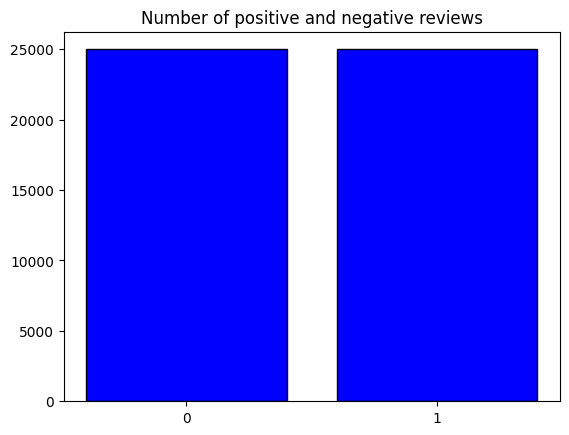

In [16]:
import matplotlib.pyplot as plt

hist = [1 if sentiment == 'positive' else 0 for sentiment in data_sentiment_labels]
plt.hist(hist, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.8, color='blue')
plt.title("Number of positive and negative reviews")
plt.xticks([0, 1])
plt.grid(False)
plt.show()

In [17]:
example = data["Cleaned_Reviews"][10]
tokens = nltk.word_tokenize(example)
tokens

['phil',
 'alien',
 'one',
 'quirky',
 'film',
 'humour',
 'based',
 'around',
 'oddness',
 'everything',
 'rather',
 'actual',
 'punchlinesat',
 'first',
 'odd',
 'pretty',
 'funny',
 'movie',
 'progressed',
 'didnt',
 'find',
 'joke',
 'oddness',
 'funny',
 'anymoreits',
 'low',
 'budget',
 'film',
 'thats',
 'never_problem',
 'pretty',
 'interesting',
 'character',
 'eventually',
 'lost',
 'interesti',
 'imagine',
 'film',
 'would',
 'appeal',
 'stoner',
 'currently',
 'partakingfor',
 'something',
 'similar',
 'better',
 'try',
 'brother',
 'another',
 'planet']

In [18]:
def analyze_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_score = sia.polarity_scores(text)
    return "positive" if sentiment_score['compound'] >= 0 else "negative"


In [19]:
data["Predicted_Sentiment"] = data["Cleaned_Reviews"].apply(analyze_sentiment)


In [24]:
example_review = data['Cleaned_Reviews'][15]
example_sentiment = data['sentiment'][15]
example_predicted_sentiment = data['Predicted_Sentiment'][15]
print("Example: ", example_review)
print("Dataset sentiment: ", example_sentiment)
print("Predicted sentiment using VADER: ", example_predicted_sentiment)


Example:  kind drawn erotic scene realize one amateurish unbelievable bit film ive ever seen sort like high school film project rosanna arquette thinking stock character bizarre supposed midwest town pretty hard get involved one no_lesson learned no_brilliant insight stilted quite ridiculous lot skin intrigue videotaped nonsensewhat bisexual relationship nowhere heterosexual encounter absurd dance everybody playing stereotyped role give one pas like million mile bad wasted film money could spent starving child aid africa
Dataset sentiment:  negative
Predicted sentiment using VADER:  negative


In [25]:
def analyze_emotion(text):
    emotion = NRCLex(text)
    emotion_scores = emotion.raw_emotion_scores
    positive_emotions = {"joy", "trust", "anticipation", "surprise"}
    negative_emotions = {"anger", "disgust", "fear", "sadness"}
    pos_score = sum(emotion_scores.get(e, 0) for e in positive_emotions)
    neg_score = sum(emotion_scores.get(e, 0) for e in negative_emotions)
    return emotion_scores, pos_score, neg_score


In [27]:
data[["Emotion_Scores", "Positive_Score", "Negative_Score"]] = data["Cleaned_Reviews"].apply(lambda x: pd.Series(analyze_emotion(x)))

In [29]:
example_review = data['Cleaned_Reviews'][15]
example_sentiment = data['sentiment'][15]
example_calculated_emotions = data['Emotion_Scores'][15]
print("Example: ", example_review)
print("Dataset sentiment: ", example_sentiment)
print("Calculated emotions using NRCLEX: ", example_calculated_emotions)


Example:  kind drawn erotic scene realize one amateurish unbelievable bit film ive ever seen sort like high school film project rosanna arquette thinking stock character bizarre supposed midwest town pretty hard get involved one no_lesson learned no_brilliant insight stilted quite ridiculous lot skin intrigue videotaped nonsensewhat bisexual relationship nowhere heterosexual encounter absurd dance everybody playing stereotyped role give one pas like million mile bad wasted film money could spent starving child aid africa
Dataset sentiment:  negative
Calculated emotions using NRCLEX:  {'joy': 6, 'positive': 7, 'trust': 6, 'anticipation': 5, 'negative': 11, 'surprise': 4, 'anger': 4, 'disgust': 3, 'fear': 2, 'sadness': 1}


In [30]:
data["Emotion_Based_Sentiment"] = data.apply(lambda row: "positive" if row["Positive_Score"] >= row["Negative_Score"] else "negative", axis=1)


In [31]:
example_review = data['Cleaned_Reviews'][15]
example_sentiment = data['sentiment'][15]
example_calculated_emotions = data['Emotion_Scores'][15]
example_calculated_sentiment_by_emotions = data['Emotion_Based_Sentiment'][15]

print("Example: ", example_review)
print("Dataset sentiment: ", example_sentiment)
print("Calculated emotions using NRCLEX: ", example_calculated_emotions)
print("Calculated sentiment using emotions: ", example_calculated_sentiment_by_emotions)


Example:  kind drawn erotic scene realize one amateurish unbelievable bit film ive ever seen sort like high school film project rosanna arquette thinking stock character bizarre supposed midwest town pretty hard get involved one no_lesson learned no_brilliant insight stilted quite ridiculous lot skin intrigue videotaped nonsensewhat bisexual relationship nowhere heterosexual encounter absurd dance everybody playing stereotyped role give one pas like million mile bad wasted film money could spent starving child aid africa
Dataset sentiment:  negative
Calculated emotions using NRCLEX:  {'joy': 6, 'positive': 7, 'trust': 6, 'anticipation': 5, 'negative': 11, 'surprise': 4, 'anger': 4, 'disgust': 3, 'fear': 2, 'sadness': 1}
Calculated sentiment using emotions:  positive


In [32]:
data["Sentiment_Match"] = data["sentiment"] == data["Emotion_Based_Sentiment"]

In [33]:
# Prepare data for training
X = data[["Positive_Score", "Negative_Score"]]
y = data["sentiment"].map({"positive": 1, "negative": 0})

In [34]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
# Train a RandomForestClassifier model
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
# Evaluate the model
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      4961
           1       0.64      0.64      0.64      5039

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.64      0.64      0.64     10000



In [37]:
# Test on a new review
new_review = "Not happy with the bad acting."
new_review_cleaned = preprocess_text(new_review)
print(new_review_cleaned)
new_review_emotions, new_review_pos, new_review_neg = analyze_emotion(new_review_cleaned)
new_review_features = pd.DataFrame([[new_review_pos, new_review_neg]], columns=["Positive_Score", "Negative_Score"])
new_review_sentiment = model.predict(new_review_features)
print("New Review Emotion Scores:")
for emotion, score in new_review_emotions.items():
    print(f"{emotion}: {score}")

print(f"Comparison - Positive Score: {new_review_pos}, Negative Score: {new_review_neg}")
print(f"Predicted Sentiment: {'Positive' if new_review_sentiment[0] == 1 else 'Negative'}")


not_happy bad acting
New Review Emotion Scores:
anger: 1
disgust: 1
fear: 1
negative: 1
sadness: 1
Comparison - Positive Score: 0, Negative Score: 4
Predicted Sentiment: Negative
